In [22]:
#%matplotlib inline
import sys
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/weather_mast/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/MEPS/')
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

import createFolder as cF
import calc_date as cd
import plot_sfc_spaghetti_ret as spagh
import save_fig as SF
import get_Haukeli_obs_data as obsDat
import calc_48h_acc as acc
import fill_values as fv
import plot_vertical as pvert

import os

import pandas as pd
import matplotlib as mpl
mpl.style.use('ggplot')

In [23]:
year = 2016
month = 12
tid = '00'
#tid = '18'
station = 'Haukeliseter'
savefig = 0  # 1 = yes, 0 = no

### if plot with double fence data
dofe = 1     # 1 = yes, 0 = no

In [24]:
#### days 
#t = ['17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27']
t = ['20', '21', '22', '23', '24', '25', '26', '27']
#t = ['22']

In [25]:
var_name = 'precipitation_amount_acc'
unit = '[mm]'
figdir = '../../Figures/Retrieval_MEPS/%s' %(var_name)
# Folder where the figures are being saved    
cF.createFolder('%s/' %(figdir))
form = 'png'

In [26]:
level = 'sfc'
### MEPS
ncdir_sfc = '../../Data/MEPS/%s/%s_%s' %(station,level,tid)
level = '10m'
ncdir_10m = '../../Data/MEPS/%s/%s_%s' %(station,level,tid)


################################################################
### Haukeli obs.
txtdir = '../../Data/eklima/'
txt_filename = 'Observations-hour_minutes'

################################################################
### Retrieval 
nc_dir_retrieval = '../../Data/Retrieved_SWC'

################################################################



In [27]:
# read in the Haukeliseter observation file, sorted by daily values
Haukeli = pd.read_csv('%s/%s.txt' %(txtdir, txt_filename),\
                    sep = ';',header=19, skipfooter = 11, engine= 'python')

DateHour = Haukeli['Date-Hour(UTC)']

RR_1 = Haukeli['RR_1'].astype(float)           # Precipitation (1 hour); [mm]
DD   = Haukeli['DD'].astype(float)             # Wind direction (FF); [degrees]
FF   = Haukeli['FF'].astype(float)             # Wind speed (10 meters above ground);m/s

if tid == '18':
    precip, dt_precip, hour_precip, day_precip, month_precip, year_precip = obsDat.valid_values_18UTC(RR_1, DateHour)
    dt, p, hour, dy, mm, yr = obsDat.arange_daily_18UTC(RR_1, DateHour)
if tid == '00':
    precip, dt_precip, hour_precip, day_precip, month_precip, year_precip = obsDat.valid_values(RR_1, DateHour)
    dt, p, hour, dy, mm, yr = obsDat.arange_daily(RR_1, DateHour)

   

In [28]:
idxFF = np.where(FF[:] == -9999)
idxDD = np.where(DD[:] == -9999)

FF[idxFF[0][:]] = np.nan
DD[idxDD[0][:]] = np.nan

### calculate the U, V wind component for barb plot
# http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv.html

# first calculate the mathematical wind direction in deg
md_deg = 270 - DD
for k in range(0,md_deg.shape[0]):
    if md_deg[k] <0 :
        md_deg[k] = md_deg[k] +360
md_rad = math.pi/180. * md_deg
uwind = FF*np.cos(md_rad)
vwind = FF*np.sin(md_rad)

In [29]:
U_wind, V_wind, dt_wind, hour_wind, day_wind, month_wind, year_wind = obsDat.valid_values_wind(uwind, vwind, DateHour)

In [30]:
# read in the Haukeliseter observation file, for wind gust
Haukeli_gust = pd.read_csv('%s%s_gusts.txt' %(txtdir, txt_filename),\
                    sep = ';',header=14, skipfooter = 2,engine= 'python')
# FG_1 Kraftigste vindkast (siste time)
# FX_1 Kraftigste middelvind (siste time)
FX_1 = Haukeli_gust['FX_1'].astype(float)
DX_1 = Haukeli_gust['DX_1'].astype(float)

idxFX_1 = np.where(FX_1[:] == -9999)
idxDX_1 = np.where(DX_1[:] == -9999)

FX_1[idxFX_1[0][:]] = np.nan
DX_1[idxDX_1[0][:]] = np.nan

# first calculate the mathematical wind direction in deg
md_deg_X = 270 - DX_1
for k in range(0,md_deg_X.shape[0]):
    if md_deg_X[k] <0 :
        md_deg_X[k] = md_deg_X[k] +360
md_rad_X = math.pi/180. * md_deg_X
uwind_X = FX_1*np.cos(md_rad_X)
vwind_X = FX_1*np.sin(md_rad_X)

In [31]:
U_wind_X, V_wind_X, dt_wind_X, hour_wind_X, day_wind_X, month_wind_X, year_wind_X = obsDat.valid_values_wind(uwind_X, vwind_X, DateHour)

In [32]:
fn_sfc        = dict()
fn_10m        = dict()
time_sfc      = dict()
ini_day       = []
calday        = []
calmon        = []
precipitation_amount_acc = dict()
x_wind_10m    = dict()
y_wind_10m    = dict()
lead_time_sfc = dict()
title         = dict()

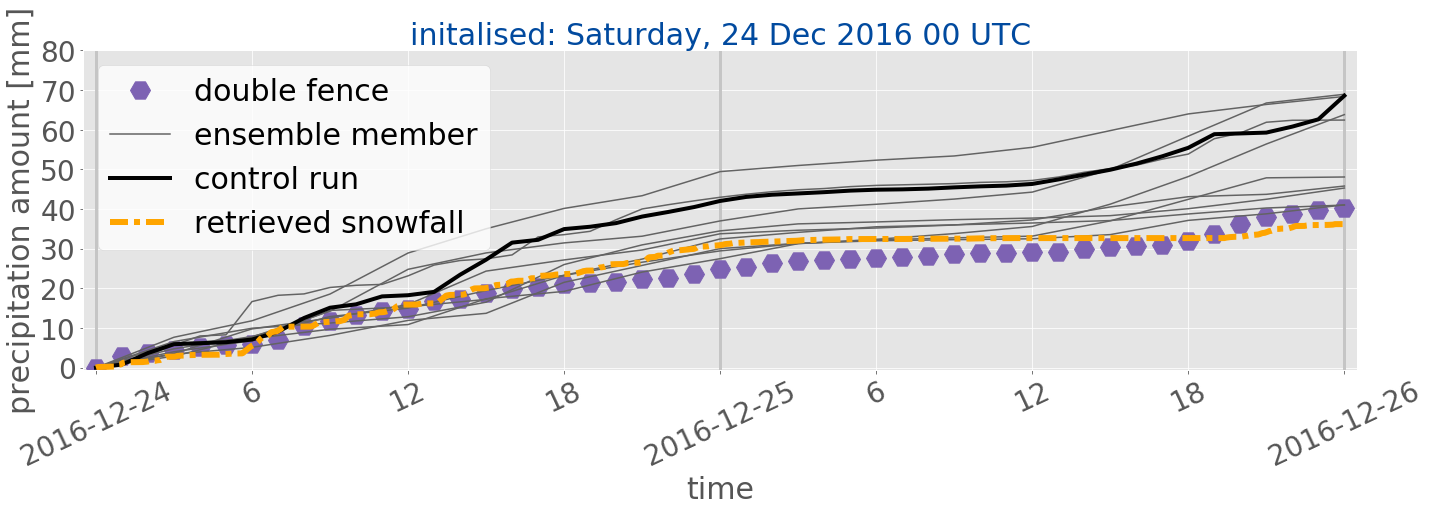

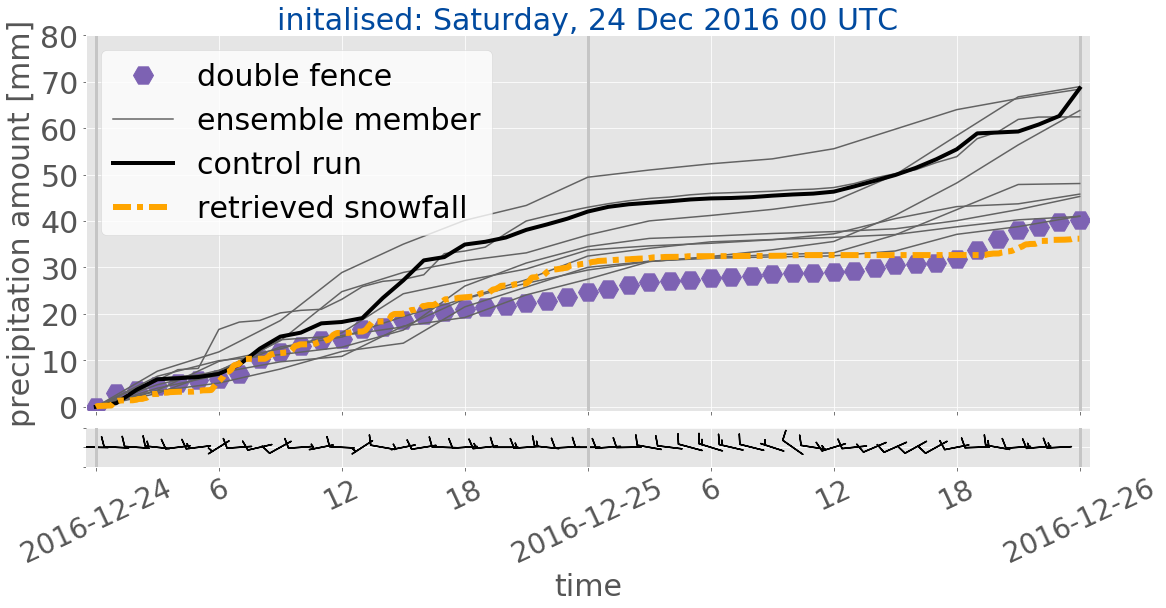

In [65]:
t = ['24']
for day in t:


    var_name_sfc = '%s' %(var_name)

    ## RETRIEVAL ######
    fn_ret1 = netCDF4.Dataset('%s/out_swc_b6_%s%s%s.nc' %(nc_dir_retrieval, year, month, day))
    fn_ret2 = netCDF4.Dataset('%s/out_swc_b6_%s%s%s.nc' %(nc_dir_retrieval, year, month, int(day)+1))
    equiv_accum1 = fn_ret1.variables['retrieved_snowfall_amount'][:,:] 
    equiv_accum2 = fn_ret2.variables['retrieved_snowfall_amount'][:,:] 


### calculate accumulation from retrieval
#srate = equiv_accum1[6,:]
    srate1 = (equiv_accum1[2,:])
    srate2 = (equiv_accum2[2,:])
    

#srate[np.where(~np.isfinite(srate))] = 0.0
#srate = srate/srate.shape[0]
    srate1[np.where(~np.isfinite(srate1))] = 0.0
    srate2[np.where(~np.isfinite(srate2))] = 0.0
    srate1 = srate1/srate1.shape[0]
    srate2 = srate2/srate2.shape[0]
    srate = np.concatenate((srate1, srate2),axis=0)
#pd.DataFrame(srate)

    acc_ret = []
    acc_ret.append(0.0)
    for i in range(0,srate.shape[0]-1):
        dix = np.nansum([acc_ret[i],srate[i]],axis = 0)
        acc_ret.append(dix)

    for ens_memb in range(0,10):
# read in the netcdf surface file
        fn_sfc[ens_memb] = netCDF4.Dataset('%s/%s%s%s_%s_%s.nc' %(ncdir_sfc,year,month,day,tid,ens_memb))
        time_sfc[ens_memb] = fn_sfc[ens_memb].variables['time']
        time_sfc[ens_memb] = fv.fill_nan(time_sfc[ens_memb][:])
# initialisation time for plotting
        ini_day = (datetime.datetime.utcfromtimestamp(time_sfc[0][0]).day)   # day of initialisation
        hh = (datetime.datetime.utcfromtimestamp(time_sfc[0][0]).hour)       # first hour of initialisation
        calday, calmon = cd.get_dayname(year, month, ini_day)
# Read in the variable name which should be plotted  
        precipitation_amount_acc[ens_memb] = fn_sfc[ens_memb].variables[var_name]
    
# read in the netcdf 10m wind file
        fn_10m[ens_memb] = netCDF4.Dataset('%s/%s%s%s_%s_%s.nc' %(ncdir_10m,year,month,day,tid,ens_memb))
# read in the wind variable
        x_wind_10m[ens_memb] = fn_10m[ens_memb].variables['x_wind_10m'][:]
        y_wind_10m[ens_memb] = fn_10m[ens_memb].variables['y_wind_10m'][:]
    



# lead time
        lead_time_sfc[ens_memb] = np.arange(0,time_sfc[ens_memb].shape[0])
# get only valuable values not nan
        #substitute missing values with nan 
        precipitation_amount_acc[ens_memb] = fv.fill_nan(precipitation_amount_acc[ens_memb][:,:])
    
#### calculate every 60 min the accumulation over 48 hours
    tot = acc.accumulation_dt60_for48h(precip, ini_day)
################

# calculate the ensemble mean of ice amount (all 10 ensemble member averaged)
    val = np.zeros(shape=(10,np.asarray(precipitation_amount_acc[0]).shape[0]))
    precip_std = []
    precip_mean = []
    for ens_memb in range(0,10):
        val[ens_memb] = np.asarray(precipitation_amount_acc[ens_memb])[:,0]
    ### std, mean
    precip_std.append(np.nanstd(val,axis=0,ddof=1))
    precip_mean.append(np.mean(val,axis=0))
    

    time_precip_mean = lead_time_sfc[0][~np.isnan(precip_mean).any(axis=0)]
    precip_mean = np.asarray(precip_mean)[~np.isnan(precip_mean)]
# get only valuable values not nan
    for ens_memb in range(0,10):
        time_sfc[ens_memb] = time_sfc[ens_memb][~np.isnan(time_sfc[ens_memb])]
        lead_time_sfc[ens_memb] = lead_time_sfc[ens_memb][~np.isnan(precipitation_amount_acc[ens_memb]).any(axis=1)]
        precipitation_amount_acc[ens_memb] = precipitation_amount_acc[ens_memb][~np.isnan(precipitation_amount_acc[ens_memb]).any(axis=1),:]
    
    
##########################################################
# spaghetti plot with all ensemble member + control
    if hh < 10:
        hh = '0%s' %(hh)
    else:
        hh = '%s' %(hh)
        

    
    title = 'initalised: %s, %s %s %s %s UTC' %(calday,ini_day,calmon,year,hh)
    var_name_sfc = var_name_sfc.split("_")
    
    if len(tot) <= 3:
        print('no double fence data')
        dofe = 0
        Xmax = 49
    else:
        dofe = 1
        Xmax = np.asarray(tot).shape[0]
    xwind_WM = []
    ywind_WM = []
    xwind_WM_gust = []
    ywind_WM_gust = []


    xwind_WM.extend(U_wind[int(day)-1][:])
    xwind_WM.extend(U_wind[int(day)][:(Xmax-U_wind[int(day)-1][:].shape[0])])
    ywind_WM.extend(V_wind[int(day)-1][:])
    ywind_WM.extend(V_wind[int(day)][:(Xmax-V_wind[int(day)-1][:].shape[0])])
    
    xwind_WM_gust.extend(U_wind_X[int(day)-1][:])
    xwind_WM_gust.extend(U_wind_X[int(day)][:(Xmax-U_wind_X[int(day)-1][:].shape[0])])
    ywind_WM_gust.extend(V_wind_X[int(day)-1][:])
    ywind_WM_gust.extend(V_wind_X[int(day)][:(Xmax-V_wind_X[int(day)-1][:].shape[0])])
    
    
    fig_name = 'acc_%s%s%s_%s.png' %(year,month,ini_day,hh)
    spagh.spaghetti_sfc_dofe(lead_time_sfc, precipitation_amount_acc, tot, acc_ret,
                             Xmax, day, var_name_sfc,
                        hour, mm, dy, yr, int(ini_day), unit, title, tid, dofe)
    if savefig == 1:
        SF.save_figure_landscape(figdir, fig_name, form)
        print('plot saved: %s/%s' %(figdir,fig_name))
    elif savefig == 0:
        plt.show()
    plt.close()
    
    fig_name = 'acc_wind_%s%s%s_%s.png' %(year,month,ini_day,hh)
#    spagh.spaghetti_sfc_dofe_wind(lead_time_sfc[0], lead_time_sfc, precipitation_amount_acc, tot, acc_ret,
#                                x_wind_10m[0][:Xmax], y_wind_10m[0][:Xmax],
 #                                 xwind_WM, ywind_WM,
  #                           Xmax, day, var_name_sfc,
   #                     hour, mm, dy, yr, int(ini_day), unit, title, tid, dofe)
    
    spagh.spaghetti_sfc_dofe_wind(lead_time_sfc[0], lead_time_sfc, precipitation_amount_acc, tot, acc_ret,
                                  xwind_WM_gust, ywind_WM_gust,
                                  xwind_WM, ywind_WM,
                             Xmax, day, var_name_sfc,
                        hour, mm, dy, yr, int(ini_day), unit, title, tid, dofe)
    
    
    if savefig == 1:
        SF.save_figure_landscape(figdir, fig_name, form)
        print('plot saved: %s/%s' %(figdir,fig_name))
    elif savefig == 0:
        plt.show()
    plt.close()
    

        
    for ens_memb in range(0,10):
        fn_sfc[ens_memb].close()
    